### Step 1: Import library

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Step 2: Import training data

In [20]:
df = pd.read_csv('./training_data/GBPUSD_open_5year.csv')
df["Date"] = pd.to_datetime(df["Date"], format="%d/%m/%Y")
df.sort_values(by="Date", inplace=True)
df.set_index('Date', inplace=True)


### Step 3: Separate the data to Train, Validation & Test 

In [21]:
train_data = df.iloc[:935]
remaining_data = df.iloc[935:]
validation_size = len(remaining_data) // 2

val_data = remaining_data.iloc[:validation_size]
test_data = remaining_data.iloc[validation_size:]

# Print the number of samples in each set
print(f"Training Data: {len(train_data)} samples")
print(f"Validation Data: {len(val_data)} samples")
print(f"Test Data: {len(test_data)} samples")

print("Training Data Information:")
print("--------------------------")
print(f"Training Data: {train_data.shape}")
print(f"Validation Data: {val_data.shape}")
print(f"Test Data: {test_data.shape}")


Training Data: 935 samples
Validation Data: 132 samples
Test Data: 133 samples
Training Data Information:
--------------------------
Training Data: (935, 3)
Validation Data: (132, 3)
Test Data: (133, 3)


### Step 4: Scale the Open & Time data

In [22]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_data[['Open', 'Time']])

X_train_scaled = scaler.transform(train_data[['Open', 'Time']])
X_val_scaled = scaler.transform(val_data[['Open', 'Time']])
X_test_scaled = scaler.transform(test_data[['Open', 'Time']])

y_train = train_data['Open'].values
y_val = val_data['Open'].values
y_test = test_data['Open'].values

### Step 4: Implement Sliding window algorithm to covert data into Train, Validation and Test

In [28]:
def time_sequence_generator(X, y, time_interval):
    X_range, y_range = [], []
    print(X)
    print(y)
    for i in range(len(X) - time_interval): 
        X_range.append(X[i:i+time_interval])
        y_range.append(y[i+time_interval])
    return np.array(X_range), np.array(y_range)

time_interval= 60

X_train_seq, y_train_seq = time_sequence_generator(X_train_scaled, y_train, time_interval)
X_val_seq, y_val_seq = time_sequence_generator(X_val_scaled, y_val, time_interval)
X_test_seq, y_test_seq = time_sequence_generator(X_test_scaled, y_test, time_interval)


[[0.49769186 0.        ]
 [0.53346797 0.00369822]
 [0.50577034 0.00443787]
 ...
 [0.55481823 0.99852071]
 [0.55135603 0.99926036]
 [0.56866705 1.        ]]
[1.247  1.2594 1.2498 1.2451 1.2504 1.2473 1.2273 1.2329 1.2386 1.2338
 1.2409 1.2436 1.2436 1.2613 1.2547 1.2421 1.2454 1.2362 1.2287 1.2358
 1.233  1.2226 1.2199 1.2126 1.2192 1.2251 1.227  1.2212 1.219  1.2363
 1.2217 1.2323 1.2368 1.2481 1.2557 1.2597 1.2607 1.2725 1.2698 1.2722
 1.2755 1.2645 1.2539 1.2559 1.2583 1.2545 1.242  1.2361 1.2448 1.252
 1.245  1.2406 1.232  1.2268 1.2359 1.2458 1.2466 1.2468 1.2509 1.2575
 1.2596 1.2615 1.2662 1.2619 1.253  1.2623 1.2597 1.2536 1.2647 1.2749
 1.2732 1.2746 1.2789 1.2895 1.2947 1.2966 1.3046 1.3126 1.3032 1.3079
 1.3143 1.3143 1.3051 1.3089 1.3087 1.3058 1.3096 1.311  1.3099 1.3223
 1.3182 1.3144 1.3073 1.3071 1.3118 1.3193 1.3189 1.333  1.345  1.3303
 1.3271 1.3199 1.3177 1.3023 1.2996 1.2867 1.2782 1.2883 1.2854 1.3006
 1.2952 1.2962 1.2795 1.2721 1.2765 1.2714 1.2705 1.2842 1.2842 

### Step 5: Hyper parameter tuning 

In [24]:
from keras_tuner import Hyperband

def build_model(hp):
	model = Sequential()
	# Add a variable number of LSTM layers
	for i in range(hp.Int('num_layers', min_value=2, max_value=7)):
		model.add(LSTM(units=hp.Int(f'units_layer_{i+1}', min_value=32, max_value=128, step=32),
					   return_sequences=(i < hp.Int('num_layers', min_value=2, max_value=4) - 1),
					   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None))
		model.add(Dropout(hp.Float(f'dropout_layer_{i+1}', min_value=0.1, max_value=0.5, step=0.1)))

	model.add(Dense(units=hp.Int('dense_units', min_value=4, max_value=16, step=4), activation='relu'))
	model.add(Dense(units=1))

	model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
				  loss='mean_squared_error',
				  metrics=['mae', 'mse'])
	return model

# Initialize the tuner
tuner = Hyperband(
	build_model,
	objective='val_loss',
	max_epochs=50,
	factor=3,
	directory='hyperband_tuning',
	project_name='LSTM_hyperband'
)

# Perform the search
tuner.search(X_train_seq, y_train_seq, epochs=50, validation_data=(X_val_seq, y_val_seq), batch_size=32)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
lstm_model = tuner.hypermodel.build(best_hps)

# Train the model
history = lstm_model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=32, validation_data=(X_val_seq, y_val_seq))

Reloading Tuner from hyperband_tuning/LSTM_hyperband/tuner0.json
Epoch 1/100


/Users/mac/Desktop/kingston/Deep-learning-assignment/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.8153 - mae: 0.7560 - mse: 0.8153 - val_loss: 0.0060 - val_mae: 0.0762 - val_mse: 0.0060
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0137 - mae: 0.0924 - mse: 0.0137 - val_loss: 0.0054 - val_mae: 0.0729 - val_mse: 0.0054
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0073 - mae: 0.0680 - mse: 0.0073 - val_loss: 0.0012 - val_mae: 0.0331 - val_mse: 0.0012
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0062 - mae: 0.0643 - mse: 0.0062 - val_loss: 0.0020 - val_mae: 0.0439 - val_mse: 0.0020
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0060 - mae: 0.0617 - mse: 0.0060 - val_loss: 4.3679e-04 - val_mae: 0.0188 - val_mse: 4.3679e-04
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0055 - mae: 0.0593 - mse: 0.0055 - val_loss: 3.5455e-04 - val_mae: 0.0164 - val_mse: 3.5455e-04
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0054 - mae: 0.0582 - mse: 0.0054 -

### Step 6: Evaluation

In [25]:
print(f"Best Hyperparameters: {best_hps.values}")

test_loss = lstm_model.evaluate(X_test_seq, y_test_seq)
print(f"Test Loss (LSTM): {test_loss}")

y_pred = lstm_model.predict(X_test_seq)

y_pred = scaler.inverse_transform(np.column_stack((y_pred, np.zeros(y_pred.shape))))[:, 0]
y_test_actual = scaler.inverse_transform(np.column_stack((y_test_seq.reshape(-1, 1), np.zeros(y_test_seq.shape))))[:, 0]

mae_lstm = mean_absolute_error(y_test_actual, y_pred)
mse_lstm = mean_squared_error(y_test_actual, y_pred)
mape_lstm = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100 

print(f"LSTM Model Performance on Test Data:")
print(f"Mean Absolute Error (MAE): {mae_lstm:.4f}")
print(f"Mean Squared Error (MSE): {mse_lstm:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_lstm:.2f}%")


Best Hyperparameters: {'num_layers': 2, 'units_layer_1': 128, 'dropout_layer_1': 0.5, 'units_layer_2': 128, 'dropout_layer_2': 0.1, 'dense_units': 8, 'optimizer': 'adam', 'units_layer_3': 96, 'dropout_layer_3': 0.30000000000000004, 'units_layer_4': 96, 'dropout_layer_4': 0.5, 'units_layer_5': 64, 'dropout_layer_5': 0.4, 'units_layer_6': 32, 'dropout_layer_6': 0.5, 'units_layer_7': 64, 'dropout_layer_7': 0.4, 'tuner/epochs': 50, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 6.0158e-04 - mae: 0.0229 - mse: 6.0158e-04
Test Loss (LSTM): [0.0005381446098908782, 0.021261274814605713, 0.0005381446098908782]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
LSTM Model Performance on Test Data:
Mean Absolute Error (MAE): 0.0074
Mean Squared Error (MSE): 0.0001
Mean Absolute Percentage Error (MAPE): 0.48%


### Step 7: Plotting MAE & MSE

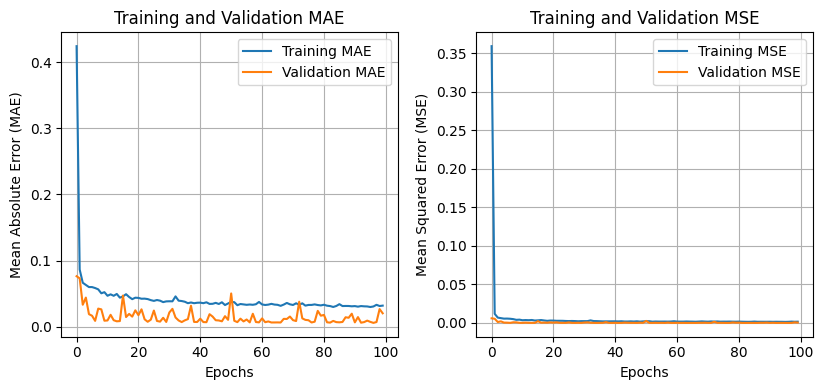

In [26]:
history_dict = history.history

plt.figure(figsize=(12, 4))

# MAE Plot
plt.subplot(1, 3, 2)
plt.plot(history_dict['mae'], label='Training MAE')
plt.plot(history_dict['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)

# MSE Plot
plt.subplot(1, 3, 3)
plt.plot(history_dict['mse'], label='Training MSE')
plt.plot(history_dict['val_mse'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Training and Validation MSE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Step 8: Save the model

In [27]:
lstm_model.save('./output/LSTM.h5')